### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))
import dataset as dsg
print(importlib.reload(dsg))

print(tf.__version__)

%load_ext memory_profiler

<module 'sequtils' from '/home/matthis/genomegraph/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/home/matthis/genomegraph/learn_specific_profiles/seq.py'>
<module 'dataset' from '/home/matthis/genomegraph/learn_specific_profiles/dataset.py'>
2.3.1


### Create random genomes as toy data 

In [3]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[1000]] * N
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
repeatPatterns = ['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes, repeatTracking, insertTracking = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                                                               repeatPatterns,
                                                               mutationProb=0.1, 
                                                               repeatMultiple=range(1,20),
                                                               repeatInsert=range(1,20),
                                                               verbose=False)
print(insertTracking)

{0: {0: {'pos': [591], 'pattern': ['ATGGCAAGGATTCAATCTACTGCAAATAAAGAG']}}, 1: {0: {'pos': [776], 'pattern': ['ATGGCAAGAATTCAATCCACCGCAAATAAAGAA']}}, 2: {0: {'pos': [658], 'pattern': ['ATGGCAAGAATTCAGTCTACTGCAAATAAGGAA']}}, 3: {0: {'pos': [854], 'pattern': ['ATTGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 4: {0: {'pos': [452], 'pattern': ['ATGGCAAGAATTCAGTCTACAGCAAATAAAGAA']}}, 5: {0: {'pos': [190], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 6: {0: {'pos': [756], 'pattern': ['ATGGCAAGAATCCAATCCACTGCGAATAAAGAA']}}, 7: {0: {'pos': [456], 'pattern': ['ATGGCCAGAATACAATCAACTGCAAATAAAGAA']}}}


In [4]:
def printExpectedPatterns():
    desiredPatternAA, repeatPatternAA = None, None
    if insertPatterns is not None:
        desiredPatternAA = []
        for pattern in insertPatterns:
            desiredPatternAA.extend(su.six_frame_translation(pattern))

        print("Desired:", desiredPatternAA)

    if repeatPatterns is not None:
        repeatPatternAA = []
        for pattern in repeatPatterns:
            repeatPatternAA.extend(su.six_frame_translation(pattern))

        print("Repeat:", repeatPatternAA)
        
    return desiredPatternAA, repeatPatternAA

desiredPatternAA, repeatPatternAA = printExpectedPatterns()

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

In [5]:
# Load Real Data
if False:
    from Bio import SeqIO
    import os
    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    datapath = "/nas-hs/projs/seedFinding/data/20210517_flanked/"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            genomes[i].extend([str(seq.seq) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            
    %memit loadRealGenomes()
    
    # load pickled Q to safe time
    Qfile = os.path.join(datapath, "backgroundAAFreqs.pkl4")
    if not os.path.isfile(Qfile):
        print("Getting Q")
        %time Q = seq.backGroundAAFreqs(genomes, True)
        with open(Qfile, 'wb') as fh:
            pickle.dump(Q, fh, protocol=4)
            
    else:
        with open(Qfile, 'rb') as fh:
            Q = pickle.load(fh)
    
else:
    %time Q = seq.backGroundAAFreqs(genomes, True)

background freqs:  15968.0 *
C 0.0312
K 0.0369
E 0.0311
W 0.0116
T 0.0615
G 0.0661
Y 0.0259
A 0.0639
I 0.0369
N 0.0277
V 0.0614
H 0.0222
S 0.0967
D 0.0328
F 0.0323
M 0.0104
R 0.0984
L 0.1036
P 0.0661
Q 0.0358
* 0.0473
CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 23.6 ms


For seedFinding data on gs3

    background freqs:  765611260.0 *
    C 0.0329
    K 0.0412
    E 0.0332
    W 0.0165
    T 0.0578
    G 0.0558
    Y 0.0334
    A 0.0510
    I 0.0546
    N 0.0361
    V 0.0578
    H 0.0321
    S 0.0929
    D 0.0280
    F 0.0406
    M 0.0172
    R 0.0710
    L 0.1039
    P 0.0558
    Q 0.0352
    * 0.0527
    CPU times: user 7min 14s, sys: 1.69 s, total: 7min 16s
    Wall time: 7min 16s

In [6]:
print(len(genomes), len(genomes[0]), len(genomes[0][0]))

8 1 1000


In [7]:
# uniform background distribution appears to be rather better
#Q = np.ones(21, dtype=np.float32)/21

#### Read in the genome

In [8]:
genomes[0][0][0:100]

'CCCCGGAGACTGATTAGATTGCTTTTCGCCTACCGATAGACCACAAAGCCTCTAATCAACGATACCTAGCCACAATTGCATCCCGCGACCTACTCAAGCC'

In [9]:
dsg.testGenerator(genomes, tile_size)

1it [00:01,  1.31s/it]

[INFO] >>> testGenerator: rc frames shifted, otherwise all good


In [ ]:
#batch_size = 1  # number of tile per batch, constrained by RAM and gradient descent performance
#batch_size = np.math.ceil(maxGenomeLen/(3 * tile_size + 2)) # 124199, OOM on greifserv3 (need 78 GB)
#batch_size = 5000
#print(batch_size)

#%time %memit 
#X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
#X.shape

In [10]:
genome_sizes = [sum([len(s) for s in genome]) for genome in genomes]
batch_size = 1  # number of X to generate per batch
tiles_per_X = 15 # number of tiles per X (-> X.shape[0])
steps_per_epoch = np.mean(genome_sizes) // (batch_size*tiles_per_X*tile_size*3)
print(genome_sizes, " -> ", steps_per_epoch)

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]  ->  0.0


In [11]:
def getDataset():
    ds = tf.data.Dataset.from_generator(
        dsg.createBatch,
        #args = (tf.constant(genomes, dtype=tf.string), tf.constant(tiles_per_X), tf.constant(tile_size)),
        args = (tf.constant(tiles_per_X), tf.constant(tile_size), tf.constant(genomes, dtype=tf.string)),
        
        # vvv used in newer versions of TF vvv
        # output_signature = (tf.TensorSpec(shape = [batch_size, len(genomes), 6, tile_size, su.aa_alphabet_size], 
        #                                   dtype = tf.float32))
        
        # vvv deprecated in newer versions of TF vvv
        output_types = tf.float32,
        output_shapes = tf.TensorShape([tiles_per_X, len(genomes), 6, tile_size, su.aa_alphabet_size])
    )
    return ds

---

#### Plot Functions

In [12]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" score={pScores[j]:.1f}") if pScores is not None else "")

In [13]:
# plot the training history as loss and accuracy curves
def plotHistory(history):
    loss = history['loss']
    Rmax = history['Rmax']
    Rmin = history['Rmin']
    Smax = history['Smax']
    Smin = history['Smin']
    epochs = range(1, len(loss) + 1)

    fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
    ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
    ax[0].set_title('Training loss')
    ax[0].legend()

    ax[1].plot(epochs, Rmax, 'bo', label = 'Rmax')
    ax[1].plot(epochs, Rmin, 'b+', label = 'Rmin')
    ax[1].plot(epochs, Smax, 'go', label = 'Smax')
    ax[1].plot(epochs, Smin, 'g+', label = 'Smin')
    ax[1].set_title('Training R and S')
    ax[1].legend();
    
    return fig, ax

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [14]:
U = 100 # number of profiles to train
k = 11 # length of profiles

In [15]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        
        #np.random.seed(1)
        #P_logit_init = np.random.normal(scale=.5, size=[k, alphabet_size, units]).astype('float32')
        
        Q1 = tf.expand_dims(Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        P_logit_like_Q = np.log(Q2.numpy())
        P_logit_init = P_logit_like_Q + np.random.normal(scale=.01, size=[k, alphabet_size, units]).astype('float32')
        
        #P_logit_init[4,19,:] = 5 # Q
        #P_logit_init[5,12,:] = 5 # S
        #P_logit_init[6,4,:] = 5 # T
        if False: # to test whether the right pattern has low loss
            P_logit_init = -100 *np.ones([k, 21, units], dtype=np.float32)
            P_logit_init[0,15,:] = 5 # M
            P_logit_init[1,7,:] = 5 # A
            P_logit_init[2,16,:] = 5 # R
            P_logit_init[3,8,:] = 5 # I
            P_logit_init[4,19,:] = 5 # Q
            P_logit_init[5,12,:] = 5 # S
            P_logit_init[6,4,:] = 5 # T
            P_logit_init[7,7,:] = 5 # A
            P_logit_init[8,9,:] = 5 # N
            P_logit_init[9,1,:] = 5 # K
            P_logit_init[10,2,:] = 5 # E

        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units
        self.history = {'loss': [],
                        'Rmax': [],
                        'Rmin': [],
                        'Smax': [],
                        'Smin': []}
        
    # return for each profile the best score at any position in the dataset
    def get_profile_match_sites(self, ds, threshold, aa_tile_size, genomes):
        # dict of dicts of dict, for each genome, map each contig to a dict that collects profile indices and positions
        #   (given that the profile matches with score above threshold for that genome, contig and position)
        sites = {}
        
        # in dataset generator, sequences get padded to fit in multiples of 3*aa_tile_size
        dna_tile_size = aa_tile_size*3
        dsSequenceLens = [[0 for _ in range(len(genomes[g]))] for g in range(len(genomes))]
        dsSequenceLenSum = [[0 for _ in range(len(genomes[g]))] for g in range(len(genomes))]
        dsGenomeLens = [0 for _ in range(len(dsSequenceLens))]
        for g in range(len(genomes)):
            for c in range(len(genomes[g])):
                dsSeqLen = np.math.ceil(len(genomes[g][c])/dna_tile_size)
                dsGenomeLens[g] += dsSeqLen
                dsSequenceLens[g][c] = dsSeqLen
                dsSequenceLenSum[g][c] = dsSeqLen
                if c >= 1:
                    dsSequenceLenSum[g][c] += dsSequenceLenSum[g][c-1] # running total
                    
        cIdx = [0 for _ in range(len(genomes))] # track contigs to convert position
        tilesIdx = 0
        for batch in ds:
            for X in batch:
                ntiles = X.shape[0]
                # update contig indices
                for g in range(len(cIdx)):
                    if dna_tile_size*tilesIdx >= dsSequenceLenSum[g][cIdx[g]]:
                        cIdx[g] += 1
                
                # get positions of best profile matches
                _, _, Z = self.call(X)              # (tilePerX, N, 6, T-k+1, U)
                for g in range(X.shape[1]):
                    if tf.reduce_max(Z[:,g,:,:,:]) >= threshold:
                        p = tf.argmax( tf.reduce_max(Z[:,g,:,:,:], axis=[0,1,2]) ).numpy() # index of the profile with best hit
                        t = tf.argmax( tf.reduce_max(Z[:,g,:,:,p], axis=[1,2]) ).numpy()   # index of the tile with best hit
                        f = tf.argmax( tf.reduce_max(Z[t,g,:,:,p], axis=[1]) ).numpy()     # index of the frame with best hit
                        r = tf.argmax( Z[t,g,f,:,p] ).numpy()                              # index of the rel. position with best hit
                        
                        if t < 3:
                            r += f
                        else:
                            r += 3-f # or so, doesn't matter for now since generator messes up rc frames anyway
                            r = aa_tile_size-r-k+1
                        
                        # pos if all tiles were concatenated
                        pos = tilesIdx*ntiles*aa_tile_size # all previous tiles
                        pos +=              t*aa_tile_size # previous tiles in X
                        pos += r
                        pos *= 3
                        
                        # pos in contig
                        if cIdx[g] > 0:
                            pos -= dsSequenceLenSum[cIdx[g]-1]
                            
                        if g not in sites:
                            sites[g] = {}
                        if cIdx[g] not in sites[g]:
                            sites[g][cIdx[g]] = {'profile': [], 'pos': [], 'score': []}
                            
                        sites[g][cIdx[g]]['profile'].append(p)
                        sites[g][cIdx[g]]['pos'].append(pos)
                        sites[g][cIdx[g]]['score'].append(Z[t,g,f,r,p].numpy())
                        
                tilesIdx += ntiles
                        
        return sites

    def getP(self):
        # P1_logit = -1000 * tf.ones([self.k, 1, self.units])
        # P2_logit = tf.stack([P1_logit, self.P_logit], axis=1)
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def getR(self):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problemt with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)
        return R
    
    def getZ(self, X):
        R = self.getR()

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                          padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension
        return Z, R
        
    def call(self, X):
        Z, R = self.getZ(X)

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R, Z

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        L1 = -tf.reduce_sum(S)
        # L1 = -tf.reduce_sum(tf.reduce_max(S, axis=[0,2]))
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        # standard deviation of entropies
        VH = tf.math.reduce_std(H, axis=0) # variance for each profile along site axis
        L2 = tf.reduce_mean(VH)
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        
        # other ideas: 
        # - std deviation of scores of different genomes
        L4 = tf.reduce_sum(tf.math.reduce_std(tf.reduce_max(S, axis=0), axis=0))
        # - minimum score of any genome
        
         # penalize multiple similarly good near-best matches in the same genome
        gamma = .1 # a small value means a more inclusive meaning of near-best
        S2 = tf.nn.softmax(gamma*S, axis=1)
        S3 = tf.reduce_max(S2, axis=1) # the closer to 1, the clearer is the champion match a winner
        S4 = tf.reduce_max(S, axis=1) # or soft max like in L1
        S5 = tf.math.multiply(S4, tf.math.square(S3)) # effectively the best score per genome is divided by the number of matches
        L5 = -tf.reduce_sum(S5)/ self.units

        # overall fit of patterns
        beta = 5.0 # the larger the harder the softmax
        S6 = tf.math.multiply(S, tf.nn.softmax(beta*S, axis=0)) # a soft version between maximizing and summing over the tiles
        L6 = -tf.reduce_sum(S6) / self.units
        L7 = L6+10*L5
        
        #return (L1+L3)/N + 50*L2, L2, L4 # + 100*L2 # (L1 + L3)/N #+ 100*L2
        return L7, (L1, L2, L4, L7) # first: loss to use in training, second: tuple of all losses for evaluation

    # return for each profile the best score at any position in the dataset
    def max_profile_scores(self, ds):
        scores = np.ones([self.units], dtype=np.float32) * -np.infty
        for batch in ds:
            for X in batch:
                S, _, _ = self.call(X)
                scores = np.maximum(np.max(S, axis=(0,1)), scores)
                                    
        return scores
    
    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, R, _ = self.call(X)
            L, _ = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])
        
        return S, R, L

    def train(self, X, epochs=1000, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))
                
    def train_ds(self, ds, steps_per_epoch, epochs, verbose=True, verbose_freq=100):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        tstart = time()
        for i in range(epochs):
            steps = 0
            Lb = []
            Smin, Smax = float('inf'), float('-inf')
            Rmin, Rmax = float('inf'), float('-inf')
            for batch in ds:
                for X in batch:
                    S, R, L = self.train_step(X)
                    Lb.append(L)
                    Rmax = max(Rmax, tf.reduce_max(R).numpy())
                    Rmin = min(Rmin, tf.reduce_min(R).numpy())
                    Smax = max(Smax, tf.reduce_max(S).numpy())
                    Smin = min(Smin, tf.reduce_min(S).numpy())
                    
                steps += 1
                if steps >= steps_per_epoch:
                    break
                    
            self.history['loss'].append(np.mean(Lb))
            self.history['Rmax'].append(Rmax)
            self.history['Rmin'].append(Rmin)
            self.history['Smax'].append(Smax)
            self.history['Smin'].append(Smin)
                    
            if verbose and (i%(verbose_freq) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _ = self.loss(S)
                tnow = time()
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())) +
                      " time: {:.2f}".format(tnow-tstart)) 

In [16]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
%time %memit specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

peak memory: 317.36 MiB, increment: 6.89 MiB
CPU times: user 156 ms, sys: 60 ms, total: 216 ms
Wall time: 333 ms


In [17]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training

In [18]:
ds = getDataset().repeat().batch(batch_size).prefetch(150)
ds_score = getDataset().batch(batch_size).prefetch(150)

In [19]:
start = time()
#%time %memit specProModel.train(X, epochs=500)
%time %memit specProModel.train_ds(ds, steps_per_epoch, epochs=200, verbose_freq=10)
end = time()
print(f"time: {end-start:.2f}")
#Audio("/home/mario/audio/fertig.mp3", autoplay=True)

epoch     0 loss=-12.6176 max R: 0.208 min R: -0.130 time: 2.25
epoch    10 loss=-89.1149 max R: 1.707 min R: -1.397 time: 5.04
epoch    20 loss=-119.7572 max R: 3.110 min R: -2.555 time: 7.64
epoch    30 loss=-146.0909 max R: 4.089 min R: -3.511 time: 10.23
epoch    40 loss=-232.1953 max R: 4.471 min R: -5.002 time: 12.87
epoch    50 loss=-317.0235 max R: 4.549 min R: -7.468 time: 15.51
epoch    60 loss=-340.3754 max R: 4.561 min R: -10.168 time: 18.09
epoch    70 loss=-347.3671 max R: 4.564 min R: -12.391 time: 20.74
epoch    80 loss=-349.2454 max R: 4.565 min R: -13.816 time: 23.31
epoch    90 loss=-350.0012 max R: 4.565 min R: -13.816 time: 25.83
epoch   100 loss=-350.4161 max R: 4.566 min R: -13.816 time: 28.37
epoch   110 loss=-350.6923 max R: 4.566 min R: -13.816 time: 31.03
epoch   120 loss=-350.8977 max R: 4.566 min R: -13.816 time: 33.64
epoch   130 loss=-351.0621 max R: 4.566 min R: -13.816 time: 36.22
epoch   140 loss=-351.1992 max R: 4.566 min R: -13.816 time: 38.68
epoch 

In [20]:
if False:
    S, R, Z = specProModel(X)
    _, (L1, L2, L4, L7) = specProModel.loss(S)
    pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    print("pScores", pScores)
    np.argsort(pScores)
    print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
           "\tL4=", L4.numpy(), "\nS=", S.numpy())
    #print ("R", R.numpy())

(<Figure size 1080x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Training loss'}>,
        <AxesSubplot:title={'center':'Training R and S'}>], dtype=object))

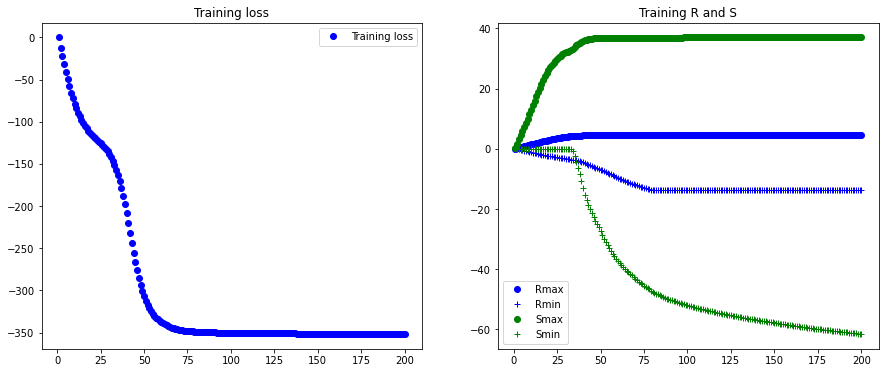

In [21]:
plotHistory(specProModel.history)

### Visualize resulting profiles as sequence logos

In [22]:
printExpectedPatterns()

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


(['MARIQSTANKE',
  'WQEFNLLQIK',
  'GKNSIYCK*R',
  'FFICSRLNSCH',
  'SLFAVD*ILA',
  'LYLQ*IEFLP'],
 ['REPEATAEPER',
  'ENLKLLLNLK',
  'RT*SYC*T*K',
  'SFRFSSSFRFS',
  'LSGSAVASGS',
  'FQVQQ*LQVL'])

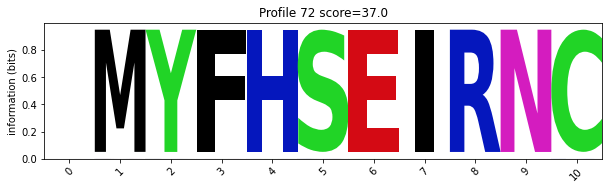

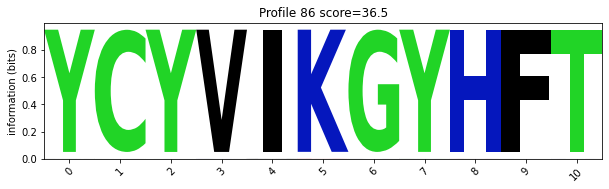

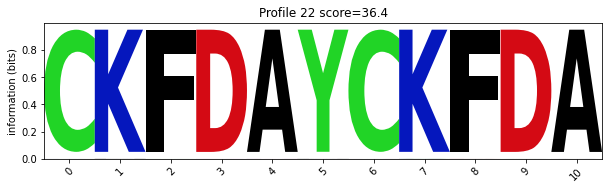

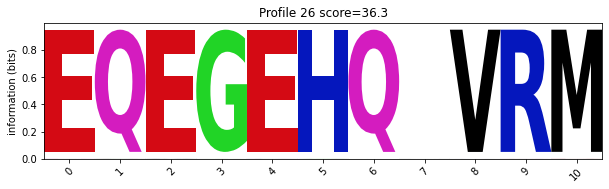

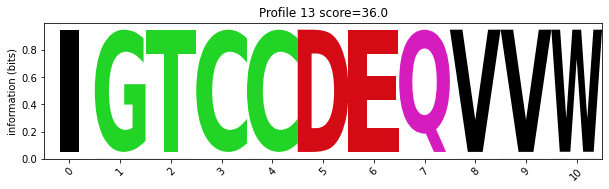

In [23]:
P = specProModel.getP()
pScores = specProModel.max_profile_scores(ds_score)
plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)

---

## Profile Score Distribution

In [24]:
R = specProModel.getR()
minscore = np.array(R).min() * specProModel.k # profile matches not at all
maxscore = np.array(R).max() * specProModel.k # all bases match perfectly
print(minscore, ",", maxscore)
minscore = np.math.floor(minscore)
maxscore = np.math.floor(maxscore)

-151.97061824798584 , 50.22648239135742


     P:     (k, alphSize, U) 
     X:     (tilesPerX, N, 6, T, alphSize) 
     Z:     (tilesPerX, N, 6, T-k+1, U)
     S:     (tilesPerX, N, U)

In [25]:
scoreBins = dict([(b,0) for b in range(minscore, maxscore)])
assert k == R.shape[0]
Scollect = []

ds_score = getDataset().batch(batch_size).prefetch(150)
for batch in ds_score:
    for X in batch:
        S, _, Z = specProModel(X)
        Scollect.extend(np.array(S).flatten())
        #for s in np.array(Z[:,:,:,:,:]).flatten():
        for s in np.array(S).flatten():
            score = np.math.floor(s)
            assert score in scoreBins, str(score)+" ("+str(s)+")"
            scoreBins[score] += 1

(array([4.53e+02, 2.05e+02, 6.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        1.12e+04, 0.00e+00, 7.00e+00, 1.28e+02]),
 array([-61.591984 , -51.735344 , -41.878704 , -32.022068 , -22.165428 ,
        -12.308788 ,  -2.4521492,   7.40449  ,  17.26113  ,  27.117767 ,
         36.974407 ], dtype=float32),
 <BarContainer object of 10 artists>)

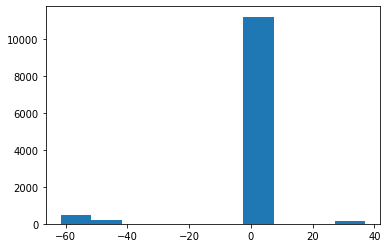

In [26]:
plt.hist(Scollect)

<BarContainer object of 202 artists>

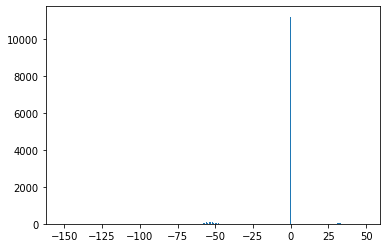

In [27]:
plt.bar(list(scoreBins.keys()), [scoreBins[k] for k in scoreBins])

---

### Profile Match Sites

In [28]:
ds_sites = getDataset().batch(batch_size).prefetch(150)
sites = specProModel.get_profile_match_sites(ds_sites, 1, tile_size, genomes)
sites

{0: {0: {'profile': [92], 'pos': [597], 'score': [-57.743656]}},
 1: {0: {'profile': [26], 'pos': [543], 'score': [36.309387]}},
 2: {0: {'profile': [72], 'pos': [30], 'score': [-81.012085]}},
 3: {0: {'profile': [86], 'pos': [366], 'score': [-86.15143]}},
 4: {0: {'profile': [13], 'pos': [486], 'score': [35.97698]}},
 5: {0: {'profile': [4], 'pos': [195], 'score': [-45.32902]}},
 6: {0: {'profile': [22], 'pos': [825], 'score': [-89.231476]}},
 7: {0: {'profile': [92], 'pos': [462], 'score': [-58.244495]}}}

In [29]:
print(insertTracking)

{0: {0: {'pos': [591], 'pattern': ['ATGGCAAGGATTCAATCTACTGCAAATAAAGAG']}}, 1: {0: {'pos': [776], 'pattern': ['ATGGCAAGAATTCAATCCACCGCAAATAAAGAA']}}, 2: {0: {'pos': [658], 'pattern': ['ATGGCAAGAATTCAGTCTACTGCAAATAAGGAA']}}, 3: {0: {'pos': [854], 'pattern': ['ATTGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 4: {0: {'pos': [452], 'pattern': ['ATGGCAAGAATTCAGTCTACAGCAAATAAAGAA']}}, 5: {0: {'pos': [190], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 6: {0: {'pos': [756], 'pattern': ['ATGGCAAGAATCCAATCCACTGCGAATAAAGAA']}}, 7: {0: {'pos': [456], 'pattern': ['ATGGCCAGAATACAATCAACTGCAAATAAAGAA']}}}


---

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [ ]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #_, (L1, L2, L4, L7) = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [ ]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [ ]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [ ]:
if False:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")
        
else:
    P = specProModel.getP()
    profiles = aaFromProfiles(P)

    if insertPatterns is not None:
        print("Desired profiles:")
        patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
        for i in range(len(patternScores)):
                print(patternProfiles[i])
                print(format_alignment(*(patternAlignments[i])))

    if repeatPatterns is not None:
        print("Undesired profiles:")
        repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
        for i in range(len(repeatScores)):
            print(repeatProfiles[i])
            print(format_alignment(*(repeatAlignments[i])))

In [ ]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))